In [1]:
#TDL
"""
Optimise runtime somehow (just make it faster)
define list of options
make all the the options possible in code (implement alternative algorithms)
configure pipeline so it takes configuration as a parameter
set up grid search
???
nobel prize
"""

'\nOptimise runtime somehow (just make it faster)\ndefine list of options\nmake all the the options possible in code (implement alternative algorithms)\nconfigure pipeline so it takes configuration as a parameter\nset up grid search\n???\nnobel prize\n'

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import sys
import os
from non_layered_neural_net import nlnn



In [3]:
#remove later
sys.argv[0] = "1"

In [4]:
#Run_hyperparameters
training_run = int(sys.argv[0])
neuron_count=300
connection_probability_dropoff=3
connection_probability_scalar=0.00003
input_layer_connectivity_multiplyer=50
output_layer_connectivity_multiplyer=20
weight_initialisation_range=2
distances_from_input_output_layer_to_main_neuron_field=0.1
hidden_neuron_connections = 7
input_neuron_connections = 10
output_neuron_connections = 10
inference_steps = 8

n_closes_neurons_connection_probability="connection_prob"  #"connection_prob" /"n_closest"
activation_function="sigmoid" #relu

generation_size=10
n_survivors=3
mutation_range=0.1
training_set_size=1000
mutation_range_reducing_interval="none"
mutation_range_reducing_factor="none"

reducing_mutaiton_range="no"
stochastic_mutation_range="yes"
multiple_training_sets="yes"
keep_best_of_n_generations_keep_n_best="keep_n_best"
allow_topological_modification="no"
non_uniform_distribution_in_stochastic_mutation_range="no"


In [5]:
#this function produces a configuration of parameters based on an input number. this allows the python script to be run with just one parameter instead of 8

def get_configuration(index):
    base_config = {
        "neuron_count": 1000,
        "connection_probability_dropoff": 3.0,
        "hidden_neuron_connections": 6,
        "inference_steps": 8,
        "n_survivors": 3,
        "activation_function": "leaky_relu",
    }

    params_to_evaluate = list(base_config.keys())
    param_index = index // 5
    run_index = index % 5

    param = params_to_evaluate[param_index]

    if param == "neuron_count":
        base_config[param] = int((np.linspace(9, 19, 5) ** 2.5)[run_index])
    elif param == "connection_probability_dropoff":
        base_config[param] = np.linspace(1, 4, 5)[run_index]
    elif param == "hidden_neuron_connections":
        base_config[param] = int(np.linspace(3, 20, 5)[run_index])
        base_config["n_closes_neurons_connection_probability"] = "n_closest"
    elif param == "inference_steps":
        base_config[param] = int(np.linspace(6, 20, 5)[run_index])
    elif param == "n_survivors":
        base_config[param] = int(np.linspace(1, 15, 5)[run_index])
    elif param == "activation_function":
        options = ["relu", "leaky_relu"]
        base_config[param] = options[run_index % len(options)]

    return base_config


In [6]:
config = {         "training_run":training_run,
                   "neuron_count":neuron_count,
                   "connection_probability_dropoff":connection_probability_dropoff,
                   "connection_probability_scalar":connection_probability_scalar,
                   "input_layer_connectivity_multiplyer":input_layer_connectivity_multiplyer,
                   "output_layer_connectivity_multiplyer":output_layer_connectivity_multiplyer,
                   "weight_initialisation_range":weight_initialisation_range,
                   "n_closes_neurons_connection_probability":n_closes_neurons_connection_probability,
                   "hidden_neuron_connections" : hidden_neuron_connections,
                   "input_neuron_connections" : input_neuron_connections,
                   "output_neuron_connections" : output_neuron_connections,
                   "inference_steps" : inference_steps,
                   "activation_function":activation_function,
                   "generation_size":generation_size,
                   "n_survivors":n_survivors,
                   "mutation_range":mutation_range,
                   "training_set_size":training_set_size,
                   "mutation_range_reducing_interval":mutation_range_reducing_interval,
                   "mutation_range_reducing_factor":mutation_range_reducing_factor,
                   "reducing_mutaiton_range":reducing_mutaiton_range,
                   "stochastic_mutation_range":stochastic_mutation_range,
                   "multiple_training_sets":multiple_training_sets,
                   "allow_topological_modification":allow_topological_modification
            }



In [7]:
settings = get_configuration(int(sys.argv[0]))
for i in settings.keys():
    config[i]=settings[i]
for i in config.keys():   
    print(i,":",config[i])

training_run : 1
neuron_count : 448
connection_probability_dropoff : 3.0
connection_probability_scalar : 3e-05
input_layer_connectivity_multiplyer : 50
output_layer_connectivity_multiplyer : 20
weight_initialisation_range : 2
n_closes_neurons_connection_probability : connection_prob
hidden_neuron_connections : 6
input_neuron_connections : 10
output_neuron_connections : 10
inference_steps : 8
activation_function : leaky_relu
generation_size : 10
n_survivors : 3
mutation_range : 0.1
training_set_size : 1000
mutation_range_reducing_interval : none
mutation_range_reducing_factor : none
reducing_mutaiton_range : no
stochastic_mutation_range : yes
multiple_training_sets : yes
allow_topological_modification : no


In [8]:
#load dataset
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
#one hot encode
def one_hot_encode(x):
    out = np.zeros((len(x), max(x)+1))
    for i in range(len(x)):
        out[i][x[i]] = 1
    return out

y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
#flatten images
x_train = train_X.reshape(len(train_X), 28*28)
x_test = test_X.reshape(len(test_X), 28*28)

x_test = np.array_split(x_test, 1)
y_test_ohe = np.array_split(y_test_ohe, 1)

In [9]:
def create_population(population_size):
    population = []
    print("Creating networks")
    for i in range(population_size):
        net = nlnn(output_neurons = 10, hidden_neurons = config["neuron_count"])
        if config["n_closes_neurons_connection_probability"] == "connection_prob":
            net.initialise_structure(connection_probability_dropoff=config["connection_probability_dropoff"], connection_probabily_scalar=config["connection_probability_scalar"], input_connection_prob_multiplyer = config["input_layer_connectivity_multiplyer"], output_connection_prob_multiplyer = config["output_layer_connectivity_multiplyer"])
        elif config["n_closes_neurons_connection_probability"] == "n_closest":
            net.initialise_structure_n_closest(hidden_neuron_connections = config["hidden_neuron_connections"], input_neuron_connections = config["input_neuron_connections"], output_neuron_connections = config["output_neuron_connections"])
        #net.initialise_randomly()
        population.append(net)
        print("|", end="")

    print("done!")
    return population


In [10]:
def get_perf(t):
        return t[0]

#measure performance of all the networks
def evaluate_performance(population, x, y):
    performances = []
    print("evaluating performances", end="")
    for net in population:
        predictions, result = net.predict(x, config["inference_steps"])
        correct_count = len(x)-(np.sum(np.abs(y - predictions))/2)
        loss = np.sum(np.abs(y - result))
        performances.append((loss/float(len(x)), net, correct_count/len(x)))
        print("|", end="")
    print(" done!", end=" ")
    #sort by best performance
    performances.sort(key = get_perf, reverse = True)
    return performances



In [11]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_net(net, x, y):
    predictions = net.predict(x, config["inference_steps"])[0]
    correct_count = len(x) - (np.sum(np.abs(y - predictions)) / 2)
    performance = correct_count / len(x)
    return (performance, net)

def evaluate_performance_fast(population, x, y):
    with ThreadPoolExecutor() as executor:
        performances = list(executor.map(evaluate_net, population, [x] * len(population), [y] * len(population)))

    print("Evaluation done!")

    # Sort by best performance
    performances.sort(key=lambda x: x[0], reverse=True)
    return performances


In [12]:
def repopulate(evaluated_networks, mutation_range, n):
    offspring_per_network = int(population_size/n)
    parents = [i[1] for i in evaluated_networks[:n]]
    offspring = []
    for net in parents:
        net_offspring = net.reproduce(min(offspring_per_network, population_size - (len(offspring) + offspring_per_network)), mutation_range)
        offspring.extend(net_offspring)
    next_gen = parents + offspring
    return next_gen


In [13]:
performance_over_time = []
test_sets_used = []
mutation_ranges = []

Creating networks
||||||||||done!
evaluating performances|||||||||| done! best performer of this generation : 72621.71346483586
generation 2  test set: 0 evaluating performances|||||||||| done!  best: accuracy 0.1023 loss: 72621.71346483586
mutating in range: 0.05735008141862215


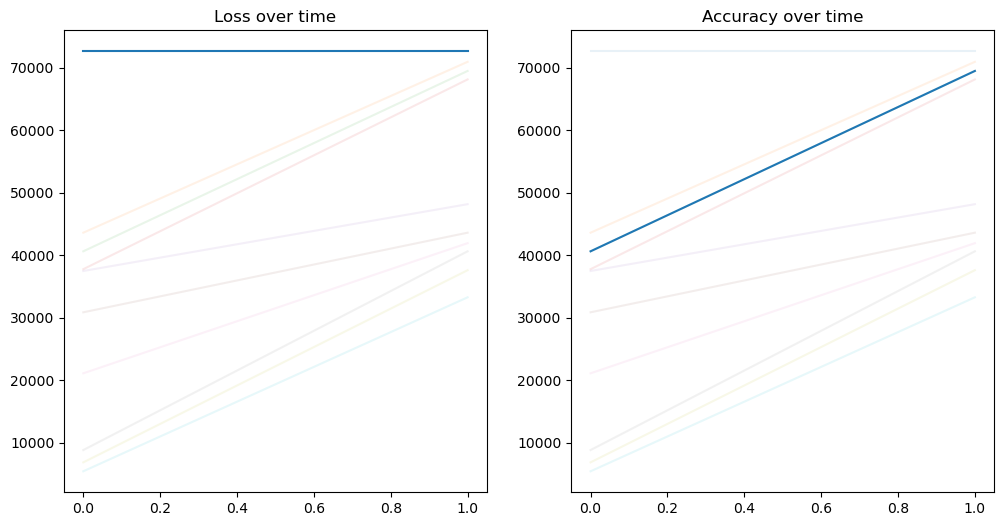

average best of last 100 generations 72621.71346483586
generation 3  test set: 0 evaluating performances|||||||||| done!  best: accuracy 0.0993 loss: 76029.81642545128
mutating in range: 0.027339741520214112
generation 4  test set: 0 evaluating performances|||||||||| done!  best: accuracy 0.0986 loss: 78962.93377040655
mutating in range: 0.04641759488603692
generation 5  test set: 0 evaluating performances|||||||||| done!  best: accuracy 0.0992 loss: 81448.87305320191
mutating in range: 0.06053781831673891
generation 6  test set: 0 evaluating performances|||||||||| done!  best: accuracy 0.0979 loss: 87636.85266837635
mutating in range: 0.02535232732930818
generation 7  test set: 0 evaluating performances||||

KeyboardInterrupt: 

In [14]:
#Training loop
    #loading hyperparameters
n = config["n_survivors"]
mutation_range = config["mutation_range"]
population_size = config["generation_size"]
population_size = config["generation_size"]
print_graphs = True

networks = create_population(population_size)
evaluated_networks = evaluate_performance(networks, x_test[0], y_test_ohe[0])
print("best performer of this generation :", evaluated_networks[0][0])
performance_over_time.append(np.array(evaluated_networks)[:,0])
next_generation = repopulate(evaluated_networks, mutation_range,n)

generations = 5000
test_set = 0
for gen in range(generations):
    if(config["reducing_mutaiton_range"]=="yes"):
        if(gen%config["mutation_range_reducing_interval"]==0 and gen!=0): 
            mutation_range/=config["mutation_range_reducing_factor"]
            print("decreasing mutation range from",mutation_range*config["mutation_range_reducing_factor"],"to",mutation_range)
    print("generation "+str(len(performance_over_time)+1), end=" ")

    if False and config["multiple_training_sets"] == "yes" and len(performance_over_time)%100 == 0 and gen!=0:
        test_set = np.random.randint(4)
    test_sets_used.append(test_set)
    print(" test set:",test_set,end=" ")
    evaluated_networks = evaluate_performance(next_generation, x_test[test_set], y_test_ohe[test_set])
    print(" best: accuracy", evaluated_networks[0][2], "loss:", evaluated_networks[0][0])
    performance_over_time.append(np.array(evaluated_networks)[:,0])
    generational_mutation_range = mutation_range
    if config["stochastic_mutation_range"]=="yes": #change back
        generational_mutation_range = np.random.rand() * mutation_range
    mutation_ranges.append(generational_mutation_range)
    print("mutating in range:", generational_mutation_range)
    next_generation = repopulate(evaluated_networks, generational_mutation_range, config["n_survivors"])
    if(gen%10==0) and print_graphs:
        plt.figure(figsize=(12, 6))  # Create a new figure, optional figsize argument sets the size of the figure in inches

        # Subplot for the loss
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
        plt.plot(np.array(performance_over_time), alpha=0.1)
        plt.plot(np.array(performance_over_time)[:,0])
        plt.title("Loss over time")  # Optional title for the first plot

        # Subplot for the accuracy
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
        plt.plot(np.array(performance_over_time), alpha=0.1)
        plt.plot(np.array(performance_over_time)[:,2])
        plt.title("Accuracy over time")  # Optional title for the second plot

        plt.show()
        print("average best of last 100 generations",np.average(np.array(performance_over_time)[-100:,0]))
    

In [ ]:
#visualising performance across the 10 different sets
def visualise_performance():
    performance_hist = np.array(performance_over_time)[-len(test_sets_used):,0]
    set_perf = []
    for i in range(10):
        set_perf.append([])
    for i in range(len(test_sets_used)-10):
        set_perf[test_sets_used[i]].append(performance_hist[i])

    for i in set_perf:
        plt.plot(i, alpha=0.8)
    plt.show()
    """
    plt.violinplot(set_perf)
    plt.show()
    """
    performance_hist = np.array(performance_over_time)[-len(test_sets_used):]
    performance_changes = []
    for i in range(len(performance_hist)-1):
        performance_changes.append(-(np.average(performance_hist[i])-np.average(performance_hist[i+1])))

    plt.scatter(np.array(performance_changes)[:len(mutation_ranges)], np.array(mutation_ranges)[:len(performance_changes)])
    plt.xlabel('change in perform')
    plt.ylabel('Y-axis label')
    plt.title("avg performance increase vs. mutation ranges")
    plt.show()

    plt.violinplot(np.array(mutation_ranges))
    plt.title("frequency of mutation ranges")
    plt.show()


    plt.plot(performance_over_time, alpha= 0.1)
    plt.plot(np.array(performance_over_time)[:,0])
    plt.title("performance of ranked individuals")
    plt.show()


    plt.plot(np.average(np.split(np.array(performance_over_time)[:6400,0], 40),axis =1))
    plt.title("performannce over time, smoothed")
    plt.show()
    
visualise_performance()

In [ ]:
config["duration"] = duration

folder_name = 'run_'+str(training_run)
suffix = 1

while os.path.exists(folder_name):
    suffix += 1
    folder_name = f"{folder_name}_{suffix}"

os.makedirs(folder_name)


performance_over_time_array = np.array(performance_over_time)

np.savetxt(folder_name+'/training_run_'+str(training_run)+'_performance.csv', performance_over_time_array, delimiter=',')
np.savetxt(folder_name+'/training_run_'+str(training_run)+'_test_sets_used.csv', test_sets_used, delimiter=',')
np.savetxt(folder_name+'/training_run_'+str(training_run)+'_mutation_ranges.csv', mutation_ranges, delimiter=',')
np.savetxt(folder_name+'/training_run_'+str(training_run)+'_best_weights.csv', evaluated_networks[0][1].adj_matrix.toarray(), delimiter=',')
np.save(folder_name+'/training_run_'+str(training_run)+'_config.npy', np.array(config))